In [60]:
# kaggle set up in saturn cloud
#!pip install kaggle
#!chmod 600 /home/jovyan/.kaggle/kaggle.json
#!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
#!mkdir data
#!unzip skin-cancer-mnist-ham10000.zip -d data

In [1]:
# import the needed dependencies
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import pandas as pd
import sidetable
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping
#import wandb
#from wandb.keras import WandbCallback


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input


pd.options.mode.chained_assignment = None  # default='warn'

2023-01-05 10:45:47.816157: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# EDA

We create a exploratory data analysis to understand the context of our images for disease classification of skin lession

- The data is divided in to folders each one of them contains 5000 images of skin lession
- The metadata csv file contains description about the images with different features:
    - dx: Diagnosis
    - dx_type: The type of diagnosis made
    - age: Age of the patient
    - sex: Gender of the patient
    - localization: The site of the skin lession
 
From all these features we can have access to a patient by knowing his age, gender and localization of the lession, the diagnosis and diagnosis type can only be known after collecting the data.

In [2]:
image_names_p1 = glob.glob('data/HAM10000_images_part_1/*.jpg')
train_image_names = [image[image.rindex('/')+1:-4] for image in image_names_p1]
print("Total number of images in the training data is: ", len(image_names_p1))

Total number of images in the training data is:  5000


In [3]:
image_names_p2 = glob.glob('data/HAM10000_images_part_2/*.jpg')
testing_image_names = [image[image.rindex('/')+1:-4] for image in image_names_p2]
print("Total number of images in the testing data is: ", len(testing_image_names))

Total number of images in the testing data is:  5015


In [4]:
val_num = int(len(testing_image_names)*0.5)

In [6]:
val_image_names = testing_image_names[0:val_num]
test_image_names = testing_image_names[val_num::]

In [7]:
FilePath = "data/HAM10000_metadata.csv"
df = pd.read_csv(FilePath)

### Split the dataset

In [8]:
train_df = df.loc[df['image_id'].isin(train_image_names)]
train_df['folder'] =  'data/HAM10000_images_part_1/' + train_df['image_id'] + '.jpg'

In [9]:
val_df = df.loc[df['image_id'].isin(val_image_names)]
val_df['folder'] =  'data/HAM10000_images_part_2/' + val_df['image_id'] + '.jpg'

test_df = df.loc[df['image_id'].isin(test_image_names)]
test_df['folder'] =  'data/HAM10000_images_part_2/' + test_df['image_id'] + '.jpg'

<AxesSubplot:title={'center':'Frequency distribution of classes'}>

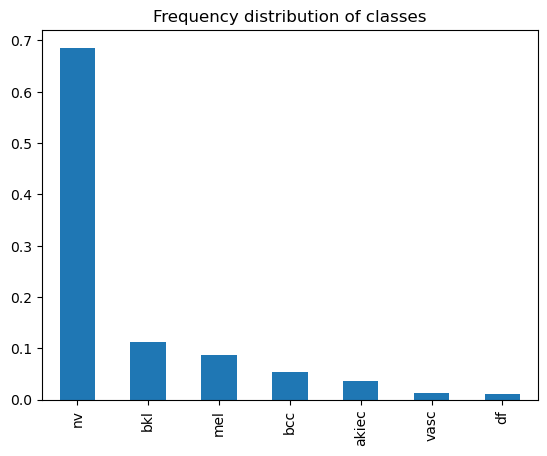

In [10]:
train_df['dx'].value_counts(normalize=True).plot(kind='bar',title='Frequency distribution of classes')

Almost 40% of our data came from melanocitc nevi, followed by melanoma (23%), benign keratosis-like lession (22%), basal cell carcinoma (10%), pyogenic granulomas and hemorrhage (4%), and dermatofibroma (3%).

<AxesSubplot:title={'center':'Age distribution of the patients'}, ylabel='Frequency'>

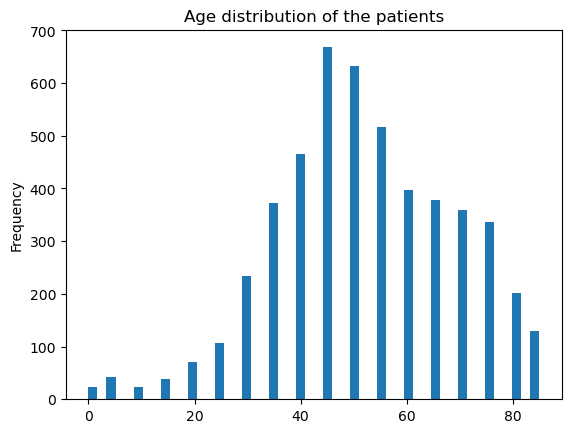

In [11]:
train_df['age'].plot(kind='hist', bins=50, title='Age distribution of the patients')

The distribution of the age of the patients shows that most of the sample are above 40 years old with most of the patients around 45 and 50 years old, the minority of the sample is young patients below 30 years old. 

<AxesSubplot:title={'center':'Frequency distribution of localization of the lession'}>

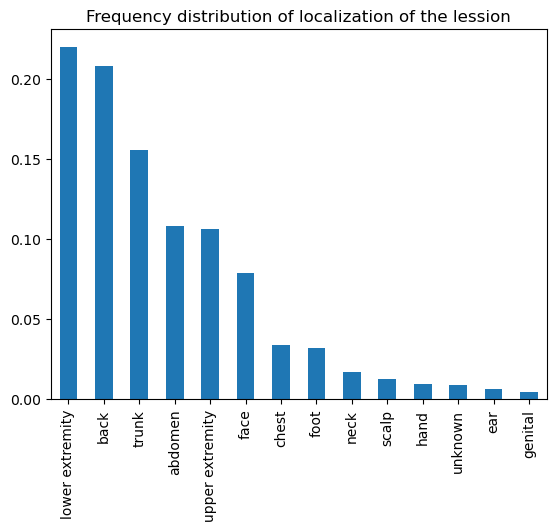

In [12]:
train_df['localization'].value_counts(normalize=True).plot(
    kind='bar',title='Frequency distribution of localization of the lession')

The most common localization of the lession is the lower extremity (22.48%) , followed by the back (20.36%), trunk (14.36%), upper extremity (11.38%), and the face (10.84%). The rest are distributed in different parts of the body. 

### Examples

In [13]:
classes = {'nv': ' melanocytic nevi',
           'mel': 'melanoma',
           'bkl': 'benign keratosis-like lesions',
           'bcc' : 'basal cell carcinoma', 
           'vasc': 'pyogenic granulomas and hemorrhage',
           'akiec': 'akie carcinomae',
           'df': 'dermatofibroma'}

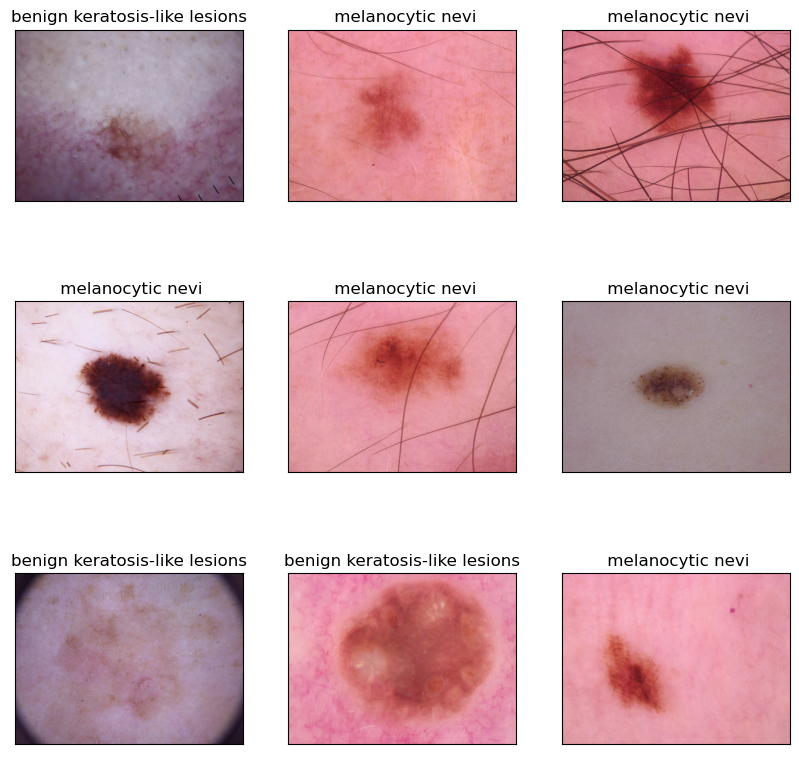

In [14]:
plot_df = train_df.sample(9).reset_index()
plt.figure(figsize=(10, 10))

for i in range(9):
    img_name = plot_df.loc[i, 'folder']
    label_str = f"{classes[plot_df.loc[i, 'dx']]}"
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(os.path.join(img_name)))
    plt.title(label_str)
    plt.xticks([])
    plt.yticks([])

In [15]:
def make_model(learning_rate, droprate, input_shape, inner_layer):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dropout = keras.layers.Dropout(droprate)(dense)
    outputs = keras.layers.Dense(7, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [29]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input

def make_model2(learning_rate, droprate, input_shape, inner_layer):
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(input_shape, input_shape, 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(input_shape, input_shape, 3))

    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    dense1 = keras.layers.Dense(inner_layer, activation='relu')(vectors)
    dense2 = keras.layers.Dense(int(inner_layer*0.5), activation='relu')(dense1)
    dense3 = keras.layers.Dense(int(inner_layer*0.15), activation='relu')(dense2)
    dropout = keras.layers.Dropout(droprate)(dense3)
    outputs = keras.layers.Dense(7, activation="linear")(dropout)

    model = keras.Model(inputs, outputs)
    
    learning_rate = learning_rate
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model

In [17]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [18]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='folder',
    y_col='dx',
    target_size=(150, 150),
    #batch_size=32,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='folder',
    y_col='dx',
    target_size=(150, 150),
    #batch_size=32,
)

Found 5000 validated image filenames belonging to 7 classes.
Found 2507 validated image filenames belonging to 7 classes.


In [19]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model(learning_rate=lr, droprate=0.0, input_shape=150, inner_layer=25)
    print(lr)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, batch_size=32)
    scores[lr] = history.history
    print()
    print()

2023-01-05 10:51:10.666748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 10:51:10.672930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 10:51:10.673866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 10:51:10.674954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

0.0001
Epoch 1/10


2023-01-05 10:51:16.875671: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-01-05 10:51:17.519003: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-05 10:51:17.519879: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-05 10:51:17.519917: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-05 10:51:17.520910: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-05 10:51:17.521004: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


157/157 [==============================] - 94s 567ms/step - loss: 1.2073 - accuracy: 0.6444 - val_loss: 1.0751 - val_accuracy: 0.6609
Epoch 2/10
157/157 [==============================] - 74s 469ms/step - loss: 0.9410 - accuracy: 0.7008 - val_loss: 0.9800 - val_accuracy: 0.6741
Epoch 3/10
157/157 [==============================] - 74s 471ms/step - loss: 0.8772 - accuracy: 0.7134 - val_loss: 0.9364 - val_accuracy: 0.6849
Epoch 4/10
157/157 [==============================] - 73s 469ms/step - loss: 0.8316 - accuracy: 0.7296 - val_loss: 0.8991 - val_accuracy: 0.6925
Epoch 5/10
157/157 [==============================] - 74s 469ms/step - loss: 0.7933 - accuracy: 0.7372 - val_loss: 0.8877 - val_accuracy: 0.6937
Epoch 6/10
157/157 [==============================] - 73s 469ms/step - loss: 0.7605 - accuracy: 0.7462 - val_loss: 0.8506 - val_accuracy: 0.6941
Epoch 7/10
157/157 [==============================] - 74s 469ms/step - loss: 0.7328 - accuracy: 0.7534 - val_loss: 0.8368 - val_accuracy: 0.6

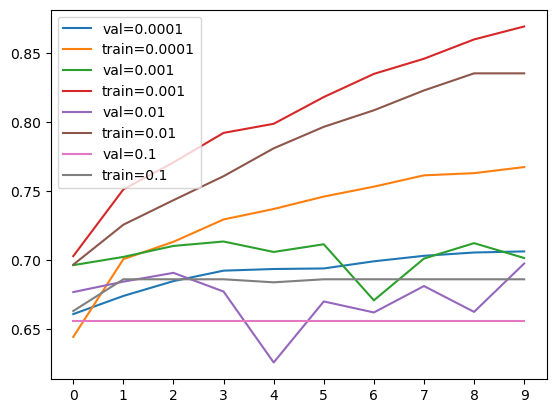

In [21]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %lr))
    plt.plot(hist['accuracy'], label=('train=%s' %lr))
plt.xticks(np.arange(10))
plt.legend()

The best learning rate based on the accuracy of the validation datast is 0.001

In [22]:
scores = {}
learning_rate = 0.001

for size in [10, 25, 100]:
    print(size)
    model = make_model(learning_rate=learning_rate, droprate=0.0, input_shape=150, inner_layer=size)
    print(size)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator)
    scores[size] = history.history
    print()
    print()

10
10
Epoch 1/10
157/157 [==============================] - 77s 476ms/step - loss: 1.1430 - accuracy: 0.6862 - val_loss: 1.0537 - val_accuracy: 0.6753
Epoch 2/10
157/157 [==============================] - 73s 468ms/step - loss: 0.9200 - accuracy: 0.7188 - val_loss: 0.9737 - val_accuracy: 0.6845
Epoch 3/10
157/157 [==============================] - 74s 470ms/step - loss: 0.8609 - accuracy: 0.7318 - val_loss: 0.9450 - val_accuracy: 0.6861
Epoch 4/10
157/157 [==============================] - 74s 469ms/step - loss: 0.8331 - accuracy: 0.7342 - val_loss: 0.9911 - val_accuracy: 0.6673
Epoch 5/10
157/157 [==============================] - 74s 469ms/step - loss: 0.8042 - accuracy: 0.7396 - val_loss: 0.9151 - val_accuracy: 0.6953
Epoch 6/10
157/157 [==============================] - 74s 470ms/step - loss: 0.7844 - accuracy: 0.7430 - val_loss: 0.9106 - val_accuracy: 0.6917
Epoch 7/10
157/157 [==============================] - 74s 471ms/step - loss: 0.7646 - accuracy: 0.7488 - val_loss: 0.9096 - 

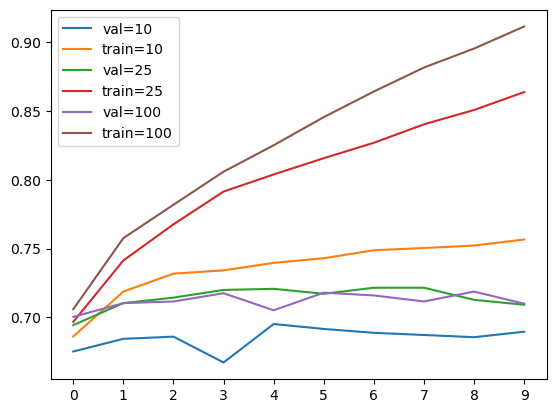

In [23]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %size))
    plt.plot(hist['accuracy'], label=('train=%s' %size))
plt.xticks(np.arange(10))
plt.legend()

In [24]:
learning_rate = 0.001
size = 25
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model(learning_rate=learning_rate, droprate=0.0, input_shape=150, inner_layer=size)
    print(droprate)
    history = model.fit(train_generator, epochs=30, validation_data=val_generator)
    scores[droprate] = history.history
    print()
    print()

0.0
0.0
Epoch 1/30
157/157 [==============================] - 77s 477ms/step - loss: 0.9073 - accuracy: 0.7064 - val_loss: 0.8500 - val_accuracy: 0.7036
Epoch 2/30
157/157 [==============================] - 74s 470ms/step - loss: 0.7414 - accuracy: 0.7442 - val_loss: 0.8518 - val_accuracy: 0.6972
Epoch 3/30
157/157 [==============================] - 73s 468ms/step - loss: 0.6661 - accuracy: 0.7680 - val_loss: 0.8019 - val_accuracy: 0.7108
Epoch 4/30
157/157 [==============================] - 74s 470ms/step - loss: 0.6031 - accuracy: 0.7902 - val_loss: 0.7970 - val_accuracy: 0.7176
Epoch 5/30
157/157 [==============================] - 73s 467ms/step - loss: 0.5539 - accuracy: 0.8038 - val_loss: 0.8663 - val_accuracy: 0.6917
Epoch 6/30
157/157 [==============================] - 73s 468ms/step - loss: 0.5269 - accuracy: 0.8150 - val_loss: 0.8021 - val_accuracy: 0.7156
Epoch 7/30
157/157 [==============================] - 74s 470ms/step - loss: 0.4813 - accuracy: 0.8376 - val_loss: 0.8180 

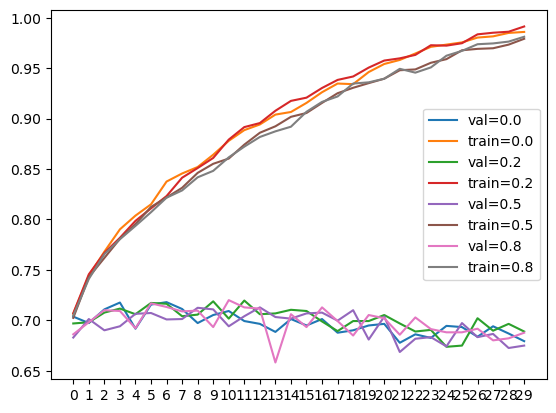

In [25]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %droprate))
    plt.plot(hist['accuracy'], label=('train=%s' %droprate))
plt.xticks(np.arange(30))
plt.legend()

Looks like we started to overfit

Potential problems:

- Imbalance dataset
- Complexity of the NN architecture

Potential solutions:

- Re-balance the dataset
- Use data augmentation
- Test a different architecture


## Test different archtecture

In [27]:
scores = {}
for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model2(learning_rate=lr, droprate=0.0, input_shape=150, inner_layer=100)
    print(lr)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, batch_size=32)
    scores[lr] = history.history
    print()
    print()

94765736/94765736 [==============================] - 2s 0us/step
0.0001
Epoch 1/10
157/157 [==============================] - 79s 482ms/step - loss: 2.0729 - accuracy: 0.0870 - val_loss: 1.8884 - val_accuracy: 0.1304
Epoch 2/10
157/157 [==============================] - 74s 472ms/step - loss: 1.8672 - accuracy: 0.0858 - val_loss: 1.8195 - val_accuracy: 0.1233
Epoch 3/10
157/157 [==============================] - 74s 469ms/step - loss: 1.8066 - accuracy: 0.0600 - val_loss: 1.7741 - val_accuracy: 0.0519
Epoch 4/10
157/157 [==============================] - 74s 472ms/step - loss: 1.7620 - accuracy: 0.0532 - val_loss: 1.7391 - val_accuracy: 0.0519
Epoch 5/10
157/157 [==============================] - 75s 476ms/step - loss: 1.7270 - accuracy: 0.0532 - val_loss: 1.7071 - val_accuracy: 0.0519
Epoch 6/10
157/157 [==============================] - 74s 473ms/step - loss: 1.6950 - accuracy: 0.0532 - val_loss: 1.6763 - val_accuracy: 0.0519
Epoch 7/10
157/157 [==============================] - 74s 

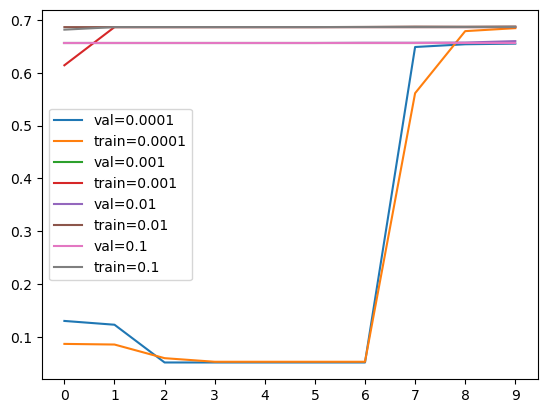

In [28]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %lr))
    plt.plot(hist['accuracy'], label=('train=%s' %lr))
plt.xticks(np.arange(10))
plt.legend()

Looks like the best learning rate of this algorithm is 0.1

In [30]:
scores = {}
learning_rate = 0.1

for size in [10, 25, 100]:
    print(size)
    model = make_model2(learning_rate=learning_rate, droprate=0.0, input_shape=150, inner_layer=size)
    history = model.fit(train_generator, epochs=10, validation_data=val_generator, batch_size=32)
    scores[size] = history.history
    print()
    print()

10
Epoch 1/10
157/157 [==============================] - 77s 477ms/step - loss: 1.2444 - accuracy: 0.6826 - val_loss: 1.1879 - val_accuracy: 0.6562
Epoch 2/10
157/157 [==============================] - 74s 469ms/step - loss: 1.1152 - accuracy: 0.6862 - val_loss: 1.1684 - val_accuracy: 0.6562
Epoch 3/10
157/157 [==============================] - 74s 470ms/step - loss: 1.1072 - accuracy: 0.6862 - val_loss: 1.1633 - val_accuracy: 0.6562
Epoch 4/10
157/157 [==============================] - 73s 469ms/step - loss: 1.1042 - accuracy: 0.6862 - val_loss: 1.1609 - val_accuracy: 0.6562
Epoch 5/10
157/157 [==============================] - 74s 470ms/step - loss: 1.1029 - accuracy: 0.6862 - val_loss: 1.1605 - val_accuracy: 0.6562
Epoch 6/10
157/157 [==============================] - 74s 475ms/step - loss: 1.1023 - accuracy: 0.6862 - val_loss: 1.1582 - val_accuracy: 0.6562
Epoch 7/10
157/157 [==============================] - 73s 470ms/step - loss: 1.1020 - accuracy: 0.6862 - val_loss: 1.1579 - val

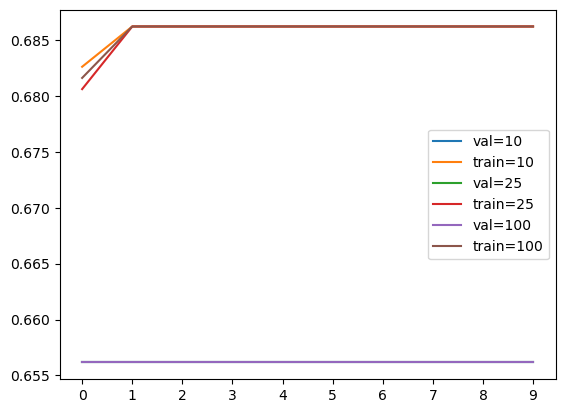

In [31]:
for size, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('val=%s' %size))
    plt.plot(hist['accuracy'], label=('train=%s' %size))
plt.xticks(np.arange(10))
plt.legend()

Complexity of the models perform worse on the validation data, also resnet doesn't seem to be a good model for this dataset.

## Final model

In [32]:
full_train = pd.concat([train_df, val_df])

In [34]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [35]:
train_full_generator = train_datagen.flow_from_dataframe(
    full_train,
    x_col='folder',
    y_col='dx',
    target_size=(150, 150),
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='folder',
    y_col='dx',
    target_size=(150, 150),
)

Found 7507 validated image filenames belonging to 7 classes.
Found 2508 validated image filenames belonging to 7 classes.


In [40]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'skin-lesion-class_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    
)

# Set up the early stopping callback with a patience of 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [41]:
learning_rate = 0.001
size = 25

model = make_model(learning_rate=learning_rate,
                   droprate=0.0, input_shape=150,
                   inner_layer=size)

history = model.fit(train_full_generator, epochs=30,
                    validation_data=test_generator, batch_size=32,
                   callbacks=[early_stopping, checkpoint])

Epoch 1/30
235/235 [==============================] - 102s 426ms/step - loss: 0.8895 - accuracy: 0.6968 - val_loss: 5.4694 - val_accuracy: 0.6487
Epoch 2/30
235/235 [==============================] - 99s 421ms/step - loss: 0.7386 - accuracy: 0.7362 - val_loss: 6.3072 - val_accuracy: 0.6435
Epoch 3/30
235/235 [==============================] - 99s 423ms/step - loss: 0.6664 - accuracy: 0.7624 - val_loss: 6.6203 - val_accuracy: 0.6029
Epoch 4/30
235/235 [==============================] - 99s 422ms/step - loss: 0.6221 - accuracy: 0.7790 - val_loss: 7.3621 - val_accuracy: 0.4677
Epoch 5/30
235/235 [==============================] - 99s 419ms/step - loss: 0.5804 - accuracy: 0.7887 - val_loss: 8.7118 - val_accuracy: 0.4665
Epoch 6/30
235/235 [==============================] - 99s 420ms/step - loss: 0.5393 - accuracy: 0.8054 - val_loss: 9.3599 - val_accuracy: 0.4179
